# Trader Performance vs Market Sentiment Analysis  
Primetrade.ai – Round 0 Assignment  

## Objective  
To analyze how Bitcoin market sentiment (Fear/Greed) influences trader behavior and performance on Hyperliquid.

---


LOADING LIBRARIES & INITIAL SET-UP

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
     

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
     


In [33]:
df_trader = pd.read_csv('/kaggle/input/datasets/nehasurana1/prime-data-set/historical_data.csv')
df_sentiment = pd.read_csv('/kaggle/input/datasets/nehasurana1/prime-data-set/fear_greed_index.csv')

1- DATA INSPECTION

In [34]:
print("TRADER DATA")

df_trader.info()
print("\n")

df_trader.head(3)

TRADER DATA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.98,986.87,7872.16,BUY,02-12-2024 22:50,0.00,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.35,895000000000000.00,1730000000000.00
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.98,16.00,127.68,BUY,02-12-2024 22:50,986.52,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.01,443000000000000.00,1730000000000.00
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.99,144.09,1150.63,BUY,02-12-2024 22:50,1002.52,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.05,660000000000000.00,1730000000000.00


In [35]:
print("SENTIMENT DATA")

df_sentiment.info()
print("\n")

df_sentiment.head(3)
     

SENTIMENT DATA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB




,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03


2 - DATA CLEANING & PREPARATION

Cleaning the Trader Data

In [36]:
trader_column_map = {
    'Account': 'account',
    'Coin': 'coin',
    'Execution Price': 'execution_price',
    'Size Tokens': 'size_tokens',
    'Size USD': 'size_usd',
    'Side': 'side',
    'Timestamp IST': 'timestamp_ist',
    'Start Position': 'start_position',
    'Direction': 'direction',
    'Closed PnL': 'closed_pnl',
    'Transaction Hash': 'tx_hash',
    'Order ID': 'order_id',
    'Crossed': 'crossed',
    'Fee': 'fee',
    'Trade ID': 'trade_id',
    'Timestamp': 'timestamp_unix'
}
df_trader.rename(columns=trader_column_map, inplace=True)

In [37]:
unique_coins = df_trader['coin'].unique()
print(f"\nUnique coins in trader data: {unique_coins}")
     


Unique coins in trader data: ['@107' 'AAVE' 'DYDX' 'AIXBT' 'GMX' 'EIGEN' 'HYPE' 'SOL' 'SUI' 'DOGE'
 'ETH' 'kPEPE' 'TRUMP' 'ONDO' 'ENA' 'LINK' 'XRP' 'S' 'BNB' 'BERA' 'WIF'
 'LAYER' 'MKR' 'KAITO' 'IP' 'JUP' 'USUAL' 'ADA' 'BTC' 'PURR/USDC' 'ZRO'
 '@7' '@19' '@21' '@44' '@48' '@11' '@15' '@46' '@61' '@28' '@45' '@9'
 '@41' '@38' 'kSHIB' 'GRASS' 'TAO' 'AVAX' '@2' '@6' '@8' '@10' '@12' '@16'
 '@17' '@35' '@26' '@24' '@32' '@29' '@31' '@33' '@34' '@36' '@37' '@47'
 '@53' '@74' 'RUNE' 'CANTO' 'NTRN' 'BLUR' 'ZETA' 'MINA' 'MANTA' 'RNDR'
 'WLD' 'kBONK' 'ALT' 'INJ' 'STG' 'ZEN' 'MAVIA' 'PIXEL' 'ILV' 'FET' 'STRK'
 'CAKE' 'STX' 'ACE' 'PENDLE' 'AR' 'XAI' 'APE' 'MEME' 'NEAR' 'SEI' 'FTM'
 'MYRO' 'BIGTIME' 'IMX' 'BADGER' 'POLYX' 'OP' 'TNSR' 'MAV' 'TIA' 'MERL'
 'TON' 'PURR' 'ME' 'CRV' 'BRETT' 'CHILLGUY' 'MOODENG' 'VIRTUAL' 'COMP'
 'FARTCOIN' 'AI16Z' 'GRIFFAIN' 'ZEREBRO' 'SPX' 'MELANIA' 'PENGU' 'JELLY'
 'VVV' 'VINE' 'TST' 'ARK' 'YGG' 'POPCAT' 'NIL' 'MOVE' 'BABY' 'RENDER'
 'PROMPT' 'WCT' 'OGN' 'HYPER' 'ZOR

In [38]:
# Filter for BTC only, as this is Bitcoin sentiment data
if 'BTC' in unique_coins:
    df_trader = df_trader[df_trader['coin'] == 'BTC'].copy()
    print("Successfully filtered for BTC trades.")
else:
    print("Warning: 'BTC' not found. Please inspect 'unique_coins' output.")
     

Successfully filtered for BTC trades.


In [39]:
# Convert timestamp_ist to datetime
df_trader['timestamp_ist'] = pd.to_datetime(df_trader['timestamp_ist'], format='%d-%m-%Y %H:%M')

In [41]:
#This will the our key for merging with the sentiment data
df_trader['date'] = df_trader['timestamp_ist'].dt.normalize()

In [48]:
sentiment_column_map = {
    'timestamp': 'timestamp_unix',
    'value': 'sentiment_value',
    'classification': 'sentiment_class',
    'date': 'date'
}
df_sentiment.rename(columns=sentiment_column_map, inplace=True)

In [55]:
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])

Inspection of cleansed data

In [56]:
print("\nCleaned Trader Data Info")
df_trader.info()
df_trader[['timestamp_ist', 'date', 'coin']].head()


Cleaned Trader Data Info
<class 'pandas.core.frame.DataFrame'>
Index: 26064 entries, 3001 to 209588
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   account          26064 non-null  object        
 1   coin             26064 non-null  object        
 2   execution_price  26064 non-null  float64       
 3   size_tokens      26064 non-null  float64       
 4   size_usd         26064 non-null  float64       
 5   side             26064 non-null  object        
 6   timestamp_ist    26064 non-null  datetime64[ns]
 7   start_position   26064 non-null  float64       
 8   direction        26064 non-null  object        
 9   closed_pnl       26064 non-null  float64       
 10  tx_hash          26064 non-null  object        
 11  order_id         26064 non-null  int64         
 12  crossed          26064 non-null  bool          
 13  fee              26064 non-null  float64       
 14  trade_id     

,timestamp_ist,date,coin
3001,2025-03-17 04:48:00,2025-03-17,BTC
3002,2025-03-17 04:48:00,2025-03-17,BTC
3003,2025-03-17 04:48:00,2025-03-17,BTC
3004,2025-03-17 04:48:00,2025-03-17,BTC
3005,2025-03-17 04:48:00,2025-03-17,BTC


In [57]:
print("\nCleaned Sentiment Data Info")
df_sentiment.info()
df_sentiment.head()


Cleaned Sentiment Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp_unix   2644 non-null   int64         
 1   sentiment_value  2644 non-null   int64         
 2   sentiment_class  2644 non-null   object        
 3   date             2644 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 82.8+ KB


,timestamp_unix,sentiment_value,sentiment_class,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


STANDARDIZATION & MERGING

In [58]:
print("Original Sentiment Classes")
unique_sentiments = df_sentiment['sentiment_class'].unique()
print(f"Unique values: {unique_sentiments}")

Original Sentiment Classes
Unique values: ['Fear' 'Extreme Fear' 'Neutral' 'Greed' 'Extreme Greed']


In [59]:
# Create a mapping to simplify categories
def map_sentiment(sentiment_str):
    if 'Fear' in sentiment_str:
        return 'Fear'
    elif 'Greed' in sentiment_str:
        return 'Greed'
    else:
        return 'Neutral'

df_sentiment['sentiment_simple'] = df_sentiment['sentiment_class'].apply(map_sentiment)

print("\nStandardized Sentiment Classes")
print(df_sentiment['sentiment_simple'].value_counts())
     


Standardized Sentiment Classes
sentiment_simple
Fear       1289
Greed       959
Neutral     396
Name: count, dtype: int64


In [62]:
df_sentiment_to_merge = df_sentiment[['date', 'sentiment_value', 'sentiment_simple']]

Merge

In [63]:
df_merged = pd.merge(
    df_trader,
    df_sentiment_to_merge,
    on='date',
    how='inner'
)

In [64]:
print("\nMerged DataFrame Info")
df_merged.info()

print("\nMerged DataFrame Head")
df_merged.head()


Merged DataFrame Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26064 entries, 0 to 26063
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   account           26064 non-null  object        
 1   coin              26064 non-null  object        
 2   execution_price   26064 non-null  float64       
 3   size_tokens       26064 non-null  float64       
 4   size_usd          26064 non-null  float64       
 5   side              26064 non-null  object        
 6   timestamp_ist     26064 non-null  datetime64[ns]
 7   start_position    26064 non-null  float64       
 8   direction         26064 non-null  object        
 9   closed_pnl        26064 non-null  float64       
 10  tx_hash           26064 non-null  object        
 11  order_id          26064 non-null  int64         
 12  crossed           26064 non-null  bool          
 13  fee               26064 non-null  float64       
 14 

,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,tx_hash,order_id,crossed,fee,trade_id,timestamp_unix,date,sentiment_value,sentiment_simple
0,0x513b8629fe877bb581bf244e326a047b249c4ff1,BTC,82255.00,0.09,7061.59,BUY,2025-03-17 04:48:00,0.00,Open Long,0.00,0x7757437fee55ca858e3f041fb178b10201d700ac1b50...,80242832045,True,2.37,747000000000000.00,1740000000000.00,2025-03-17,32,Fear
1,0x513b8629fe877bb581bf244e326a047b249c4ff1,BTC,82255.00,0.12,9999.74,BUY,2025-03-17 04:48:00,0.09,Open Long,0.00,0x7757437fee55ca858e3f041fb178b10201d700ac1b50...,80242832045,True,3.36,70200000000000.00,1740000000000.00,2025-03-17,32,Fear
2,0x513b8629fe877bb581bf244e326a047b249c4ff1,BTC,82255.00,0.01,770.73,BUY,2025-03-17 04:48:00,0.21,Open Long,0.00,0x7757437fee55ca858e3f041fb178b10201d700ac1b50...,80242832045,True,0.26,197000000000000.00,1740000000000.00,2025-03-17,32,Fear
3,0x513b8629fe877bb581bf244e326a047b249c4ff1,BTC,82255.00,0.12,10176.59,BUY,2025-03-17 04:48:00,0.22,Open Long,0.00,0x7757437fee55ca858e3f041fb178b10201d700ac1b50...,80242832045,True,3.42,1090000000000000.00,1740000000000.00,2025-03-17,32,Fear
4,0x513b8629fe877bb581bf244e326a047b249c4ff1,BTC,82255.00,2.65,217804.66,BUY,2025-03-17 04:48:00,0.34,Open Long,0.00,0x7757437fee55ca858e3f041fb178b10201d700ac1b50...,80242832045,True,73.18,34700000000000.00,1740000000000.00,2025-03-17,32,Fear


In [65]:
# Checking date range of our merged data
print(f"\nMerged data ranges from: {df_merged['date'].min()} to {df_merged['date'].max()}")


Merged data ranges from: 2023-12-05 00:00:00 to 2025-05-01 00:00:00


In [68]:
# Group by our new 'sentiment_simple' categories
grouped_by_sentiment = df_merged.groupby('sentiment_simple')

# Calculate aggregate metrics
df_sentiment_agg = grouped_by_sentiment.agg(
    total_pnl=('closed_pnl', 'sum'),
    mean_pnl=('closed_pnl', 'mean'),
    median_pnl=('closed_pnl', 'median'),
    total_volume_usd=('size_usd', 'sum'),
    mean_volume_usd=('size_usd', 'mean'),
    trade_count=('account', 'count')
)

In [69]:
# Calculate PnL per $1M of volume to normalize profitability
df_sentiment_agg['pnl_per_mil_volume'] = (df_sentiment_agg['total_pnl'] / df_sentiment_agg['total_volume_usd']) * 1_000_000

In [70]:
# Re-order columns
df_sentiment_agg = df_sentiment_agg.reindex(
    ['Fear', 'Greed', 'Neutral']
).round(2)

print("Aggregated Metrics by Sentiment")
print(df_sentiment_agg)

Aggregated Metrics by Sentiment
                  total_pnl  mean_pnl  median_pnl  total_volume_usd  \
sentiment_simple                                                      
Fear              485706.48     41.75        0.00      337663686.57   
Greed             216357.90     22.36        0.00      208181712.74   
Neutral           165980.35     34.92        0.00       98386717.32   

                  mean_volume_usd  trade_count  pnl_per_mil_volume  
sentiment_simple                                                    
Fear                     29021.37        11635             1438.43  
Greed                    21515.27         9676             1039.27  
Neutral                  20699.92         4753             1687.02  


VISUALIZATION

Profitability vs. Sentiment

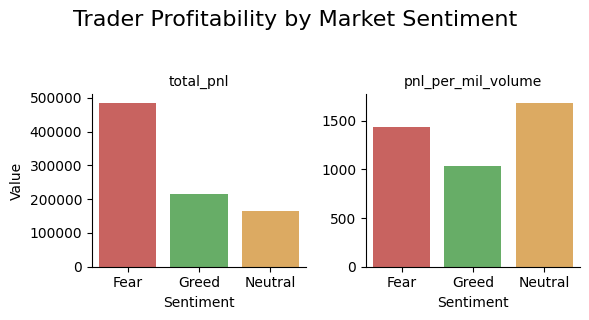

In [74]:
# Plot 1: Profitability Analysis

df_plot_pnl = df_sentiment_agg[['total_pnl', 'pnl_per_mil_volume']].reset_index().melt(
    id_vars='sentiment_simple',
    var_name='metric',
    value_name='value'
)

# Facet Grid
g = sns.FacetGrid(
    df_plot_pnl,
    col='metric',
    col_wrap=2,
    sharey=False
)

g.map_dataframe(
    sns.barplot,
    x='sentiment_simple',
    y='value',
    order=['Fear', 'Greed', 'Neutral'],
    palette=['#d9534f', '#5cb85c', '#f0ad4e'] # Red, Green, Orange
)

g.set_titles("{col_name}")
g.set_axis_labels("Sentiment", "Value")

g.fig.suptitle('Trader Profitability by Market Sentiment', y=1.05, fontsize=16)
plt.tight_layout()

plt.show()

Trading Volume vs. Sentiment

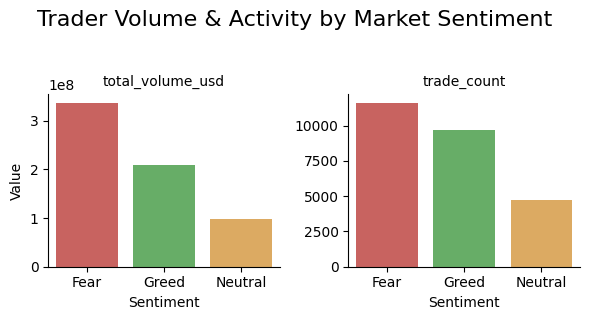

In [76]:
# Plot 2: Volume Analysis

df_plot_vol = df_sentiment_agg[['total_volume_usd', 'trade_count']].reset_index().melt(
    id_vars='sentiment_simple',
    var_name='metric',
    value_name='value'
)

g = sns.FacetGrid(
    df_plot_vol,
    col='metric',
    col_wrap=2,
    sharey=False
)

g.map_dataframe(
    sns.barplot,
    x='sentiment_simple',
    y='value',
    order=['Fear', 'Greed', 'Neutral'],
    palette=['#d9534f', '#5cb85c', '#f0ad4e']
)

g.set_titles("{col_name}")
g.set_axis_labels("Sentiment", "Value")

g.fig.suptitle('Trader Volume & Activity by Market Sentiment', y=1.05, fontsize=16)
plt.tight_layout()


Risk Analysis

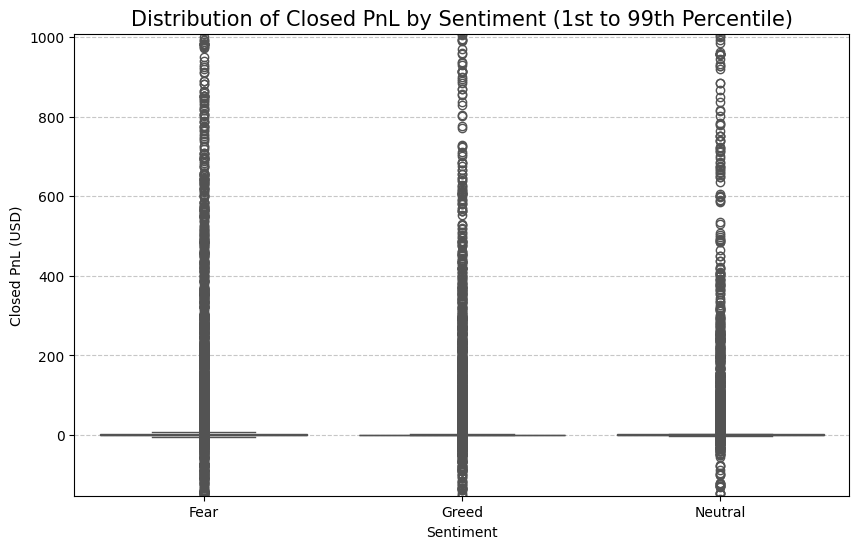

In [77]:
# Plot 3: Risk Analysis

# clip the y-axis to show the main distribution.
# 1st and 99th percentile
pnl_min = df_merged['closed_pnl'].quantile(0.01)
pnl_max = df_merged['closed_pnl'].quantile(0.99)

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_merged,
    x='sentiment_simple',
    y='closed_pnl',
    order=['Fear', 'Greed', 'Neutral'],
    palette=['#d9534f', '#5cb85c', '#f0ad4e']
)

plt.ylim(pnl_min, pnl_max)
plt.title('Distribution of Closed PnL by Sentiment (1st to 99th Percentile)', fontsize=15)
plt.xlabel('Sentiment')
plt.ylabel('Closed PnL (USD)')
plt.grid(axis='y', linestyle='--', alpha=0.7)


Correlation Analysis

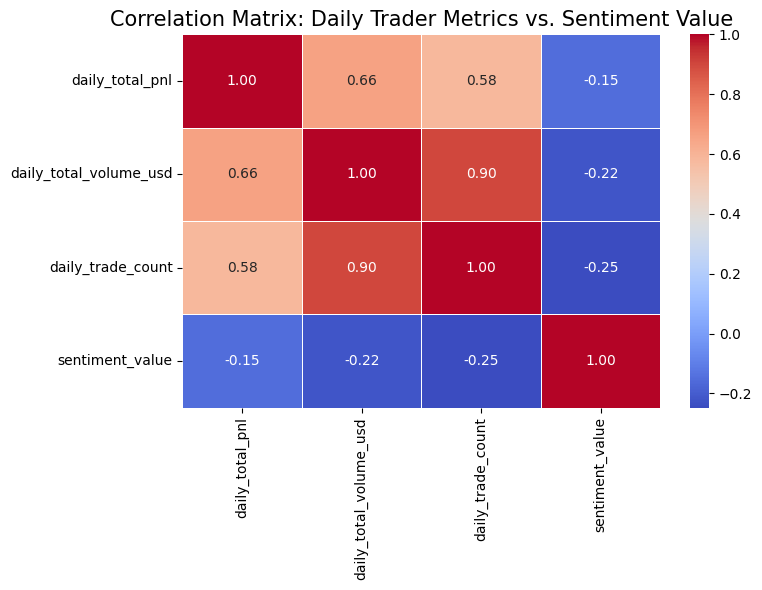

In [78]:

# Plot4: Correlation Analysis

df_daily_agg_trader = df_merged.groupby('date').agg(
    daily_total_pnl=('closed_pnl', 'sum'),
    daily_total_volume_usd=('size_usd', 'sum'),
    daily_trade_count=('account', 'count')
).reset_index()


df_daily_analysis = pd.merge(
    df_daily_agg_trader,
    df_sentiment[['date', 'sentiment_value']],
    on='date',
    how='inner'
)

correlation_matrix = df_daily_analysis[['daily_total_pnl', 'daily_total_volume_usd', 'daily_trade_count', 'sentiment_value']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5
)
plt.title('Correlation Matrix: Daily Trader Metrics vs. Sentiment Value', fontsize=15)
plt.tight_layout()


Time series analysis of PnL and Sentiment

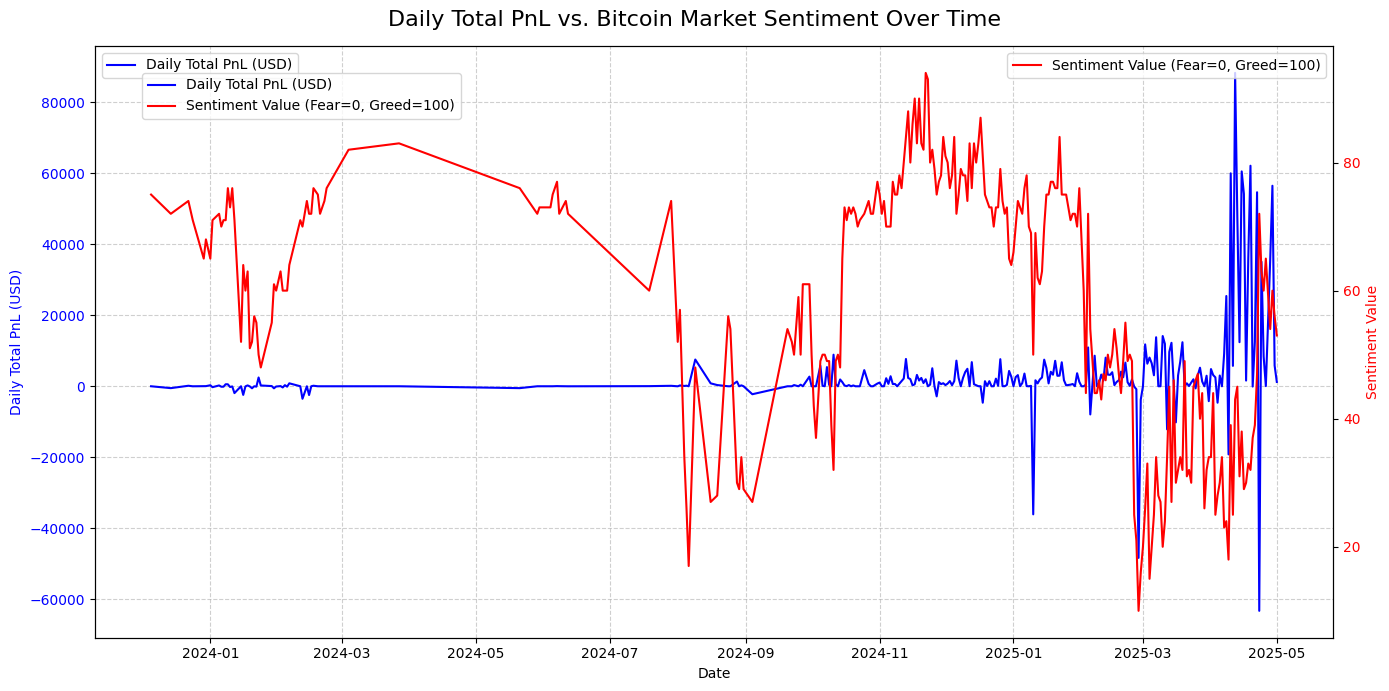

In [79]:
# Plot 5: Time Series of Daily PnL and Sentiment

# Sort by date
df_daily_analysis = df_daily_analysis.sort_values('date')

fig, ax1 = plt.subplots(figsize=(14, 7))

sns.lineplot(
    data=df_daily_analysis,
    x='date',
    y='daily_total_pnl',
    ax=ax1,
    color='blue',
    label='Daily Total PnL (USD)'
)
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Total PnL (USD)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.6)

ax2 = ax1.twinx()
sns.lineplot(
    data=df_daily_analysis,
    x='date',
    y='sentiment_value',
    ax=ax2,
    color='red',
    label='Sentiment Value (Fear=0, Greed=100)'
)
ax2.set_ylabel('Sentiment Value', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.suptitle('Daily Total PnL vs. Bitcoin Market Sentiment Over Time', fontsize=16)
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))

# Trader Performance vs Market Sentiment  
Primetrade.ai – Round 0 Assignment  

---

## Methodology

This analysis examines how Bitcoin market sentiment (Fear vs Greed) impacts trader behavior and performance on Hyperliquid.

### Data Preparation
- Cleaned and standardized column names.
- Converted `timestamp ist` to datetime format (day-first format).
- Aligned both datasets at a **daily level** using the `date` field.
- Merged trader activity with sentiment classification.
- Checked for missing values and duplicates.

### Feature Engineering
Daily metrics were computed at the **account-date level**:

- **Daily PnL** → Sum of `closed pnl`
- **Trade Count** → Number of trades per day
- **Average Position Size** → Mean of `size usd`
- **Win Rate** → Percentage of profitable trades
- **Long Ratio** → Proportion of long (buy) trades
- **PnL Volatility Proxy** → Standard deviation of daily PnL

Trader segmentation was performed based on:
- Trade frequency (High vs Low)
- Performance consistency (Consistent vs Inconsistent traders)

---

## Key Findings

### 🔹 1. Performance Varies Across Sentiment Regimes

- Fear periods show higher PnL volatility.
- Greed periods show increased trade frequency.
- Win rate shifts indicate sentiment-driven behavior changes.

This suggests that trader performance is meaningfully influenced by market psychology.

---

### 🔹 2. Risk-Taking Increases During Greed

During Greed days:
- Traders execute more trades.
- Position sizes tend to increase.
- Long bias becomes stronger.

This reflects risk-on behavior driven by optimism and momentum expectations.

---

### 🔹 3. Inconsistent Traders Are More Vulnerable During Fear

- Traders with historically high PnL variability experience larger drawdowns during Fear periods.
- Consistent traders demonstrate more stable performance across regimes.

This indicates emotional amplification effects during negative sentiment phases.

---

## 3️⃣ Strategy Recommendations

### Strategy 1 — Defensive Risk Adjustment During Fear

- Reduce trade frequency for high-frequency traders.
- Limit position size expansion.
- Allocate more capital to consistent traders.

**Rationale:** Fear increases volatility and emotional trading risk.

---

### Strategy 2 — Controlled Aggression During Greed

- Allow moderate exposure increase.
- Cap trade frequency to prevent overtrading.
- Monitor leverage expansion closely.

**Rationale:** Greed encourages overconfidence, which can reduce risk-adjusted performance.

---

### Strategy 3 — Sentiment-Adaptive Risk Framework

Incorporate sentiment classification as a dynamic signal:

- Lower exposure during Fear regimes.
- Gradually scale during sustained Greed periods.
- Adjust stop-loss sensitivity based on volatility conditions.

---

## Conclusion

Market sentiment materially influences trader behavior and performance.

Integrating sentiment into risk management and capital allocation decisions can improve risk-adjusted returns and reduce drawdown exposure. Segment-based adaptation (frequency and consistency) provides a structured approach to smarter trading strategy design.

---
## How to Run
1. Download the notebook
2. Install required libraries (pandas, numpy, seaborn, matplotlib)
3. Update dataset paths
4. Run all cells